In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import random


In [2]:
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
import datetime
warnings.filterwarnings(action='ignore')


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [99]:
DATA_PATH = '/Users/ds/Documents/data/data/'
SAVE_PATH ='/Users/ds/Documents/data/result/'
tre = pd.read_csv(DATA_PATH+"train_err_datetime.csv")
tse = pd.read_csv(DATA_PATH+"test_err_datetime.csv")

tre.time =  pd.to_datetime(tre.time)
tse.time =  pd.to_datetime(tse.time)

에러뜰경우

In [ ]:
# tre_raw = pd.read_csv('./data/train_err_data.csv')
# tp = pd.read_csv('./data/train_problem_data.csv')


# tpd=tp.user_id.value_counts().to_frame().reset_index()
# tpd.columns = ['user_id','count_e']
# tre = pd.merge(tre_raw,tpd,on='user_id',how='outer')
# tre.count_e =tre.count_e.fillna(0).astype('int')


# tse = pd.read_csv("../data/test_err_data.csv")

# tre.time =pd.to_datetime(tre.time.astype('str'))
# tse.time =pd.to_datetime(tse.time.astype('str'))

컬럼명가져오기

In [5]:
def check_unique(col,df1,df2):
    def change_len(x):
        if len(x) ==10:
            return x[:5]
        else:
            return x
    print("about",col)
    if col !='fwvers':
        train_c = set(df1[col].unique())
        test_c  = set(df2[col].unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)
    else:
        train_c = set(df1[col].apply(change_len).unique())
        test_c  = set(df2[col].apply(change_len).unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)        
        
    print()
        
    return total

model_total=check_unique('model_nm',tre,tse)
errtype_total=check_unique('errtype',tre,tse)
fwver_total = check_unique('fwver',tre,tse)


각 데이터의 변환

def dataset_trans(df,types,Num_df_user,Num_errtype,First_index):
    
    
    num_df_user = Num_df_user
    num_errtype =Num_errtype
    first_index = First_index
    num_model_change =2

    
    #----------------------------------------------errtype
    errtypes = np.zeros((num_df_user,num_errtype))
    err = df[['user_id','errtype']].values

    for inx, value in tqdm(err):
        errtypes[inx-first_index,value-1] +=1


    # ---------------------------------------------model_change
    v=df[['user_id','model_nm']]
    getdf =~(v == v.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.model_nm.apply(int)) > 0
    df_model_counts =v[logical]


    def get_model_change_id(num):
        df_mc = df_model_counts.user_id.value_counts()
        df_mc_user=list(df_mc.loc[df_mc ==num].to_frame().index)
        sort_mc_user = df.loc[df.user_id.isin(df_mc_user)].drop_duplicates(['user_id','model_nm'],keep='last').drop_duplicates('user_id',keep='first').sort_values("time").user_id
        return sort_mc_user.values

    one_m = get_model_change_id(1)
    two_m = get_model_change_id(2)
    thr_m = get_model_change_id(3)


    model_n = np.zeros((num_df_user,num_model_change))
    df['model_f'] =df['model_nm'].str[-1].astype('int')
    one_df = df.loc[df.user_id.isin(one_m)][['user_id','model_f']].drop_duplicates().values
    two_df =df.loc[df.user_id.isin(two_m)][['user_id','model_f']].drop_duplicates().reset_index(drop=True)
    two_df['tf'] = two_df.index%2
    two_df= two_df.pivot(index='user_id',columns='tf').reset_index().values
    thr_df = df.loc[df.user_id.isin(thr_m)][['user_id','model_f']].drop_duplicates().values

    for inx, value in tqdm(one_df):
        model_n[inx-first_index,0]  +=value
    for inx, value1,value2 in tqdm(two_df):
        model_n[inx-first_index,0]  +=value1
        model_n[inx-first_index,1]  +=value2

    for inx, value in tqdm(thr_df):
        model_n[inx-first_index,0]  +=value


    # ---------------------------------------------fw change
    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1

    def fwver_tran(x):
        return fwver_total_dic[x]


    df['ver_num'] = df['fwver'].apply(fwver_tran)
    fwver_np = np.zeros((num_df_user,5))

    v3=df[['user_id','ver_num']]
    getdf =~(v3 == v3.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.ver_num.apply(int)) > 0
    fwver_num=v3[logical]

    fwver_num = fwver_num.reset_index(drop=True)
    count =np.zeros(len(fwver_num),dtype=int)

    for v in range(1,len(fwver_num)):
        if fwver_num.user_id.values[v-1] ==fwver_num.user_id.values[v]:
            count[v] = count[v-1] +1


    fwver_num['count'] =count
    fw_v = fwver_num.loc[fwver_num['count'].isin([0,1,2,3,4])].pivot(index='user_id',columns='count').reset_index().fillna(0).values
    fw_v =fw_v.astype('int64')

    
    
    
    for inx, v1,v2,v3,v4,v5 in tqdm(fw_v):
        fwver_np[inx-first_index,0] =v1
        fwver_np[inx-first_index,1] =v2
        fwver_np[inx-first_index,2] =v3
        fwver_np[inx-first_index,3] =v4
        fwver_np[inx-first_index,4] =v5

    #---------------------------------------------------------- errtype_ mean_std
    df['week'] =df.time.dt.isocalendar().week

    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','week']]
    df_=datas[['user_id','week','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','week']).rename(columns = {0:'counts'}).reset_index(drop=True)

    df1 =df_.loc[df_.week ==44][['user_id','errtype','counts']].values
    df2 =df_.loc[df_.week ==45][['user_id','errtype','counts']].values
    df3 =df_.loc[df_.week ==46][['user_id','errtype','counts']].values
    df4 =df_.loc[df_.week ==47][['user_id','errtype','counts']].values
    df5 =df_.loc[df_.week ==48][['user_id','errtype','counts']].values

    day_data = np.zeros((num_df_user,42,5))
    for i, dfa in enumerate([df1,df2,df3,df4,df5]):
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m=day_data.mean(axis=2)
    std=day_data.std(axis=2)       
        

        
        
    #----------------------------------------------------------- 예은님 qulitydata
        
    #----------------------------------------------------------- errtype_ mean_std _of hour

    df['hour'] =df.time.dt.hour


    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','hour']]
    df_=datas[['user_id','hour','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','hour']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,24))
    for i in range(24):
        dfa = df_.loc[df_['hour']==i][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m2=day_data.mean(axis=2)
    std2=day_data.std(axis=2)       

    m2_1=day_data.max(axis=2)
    #----------------------------------------------------------- errtype_ mean_std _of day

    df['day'] =df.time.dt.day


    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','day']]
    df_=datas[['user_id','day','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','day']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,30))
    for i in range(30):
        dfa = df_.loc[df_['day']==(i+1)][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m3=day_data.mean(axis=2)
    std3=day_data.std(axis=2)       

    m3_1=day_data.max(axis=2) 
    #train data의 경우 label 까지 출력
    if types == 'train':
        def tf(x):
            if x>=1:
                return 1
            else:
                return 0
        df['tf'] =df.count_e.apply(tf)
        label=df[['user_id','tf']].drop_duplicates().values[:,1].reshape(-1,1)

        return [fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3     ,label]
#         return [fwver_np,model_n, errtypes, m, std    ,label]

    else:
        return [fwver_np,model_n, errtypes, m ,std ,m2,std2,m2_1,m3,m3_1,std3         ]
#         return [fwver_np,model_n, errtypes, m ,std         ]

about model_nm
train only in model_nm  set()
test only in model_nm  set()

about errtype
train only in errtype  set()
test only in errtype  set()

about fwver
train only in fwver  {'05.15.2122', '04.16.2641', '04.33.1095', '04.16.3345', '04.22.1442', '05.15.2090'}
test only in fwver  {'04.22.1170', '10.22.1770', '04.22.1448', '10.22.1780', '04.73.2569', '04.22.1772', '04.73.2577', '04.22.1478', '04.22.1608'}



In [90]:
%%time
datalist =dataset_trans(tre,'train',15000,42,10000)
train_data = np.concatenate(tuple(datalist[:-1]),axis=1)
label = datalist[-1]

print(train_data.shape)

100%|██████████| 99661/99661 [00:00<00:00, 505993.76it/s]


(15000, 385)
CPU times: user 1min 33s, sys: 9.37 s, total: 1min 42s
Wall time: 1min 43s


In [91]:
%%time
datatest2 =dataset_trans(tse,'test',14999,42,30000)
test_data = np.concatenate(tuple(datatest2),axis=1)
print(test_data.shape)

100%|██████████| 100224/100224 [00:00<00:00, 561885.21it/s]


(14999, 385)
CPU times: user 1min 25s, sys: 7.76 s, total: 1min 33s
Wall time: 1min 33s


# model

In [ ]:
[fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3     ,label]

In [313]:
feature_name_lst =[]
name_first = ['fw','model','et_c','et_wM','et_wStd','et_Hm','et_Hstd','et_Hmax','et_Dm','et_Dmax','et_Dstd']
for v in range(len(datalist)-1):
    if datalist[v].shape[1] ==42:
        target_word = name_first[v]
        for et in range(1,43):
            feature_name_lst+=[target_word+str(et)]
            
    else:
        target_word = name_first[v]
        for et in range(datalist[v].shape[1]):
            feature_name_lst+=[target_word+str(et)]
        
        
    print('data %d'%(v+1),datalist[v].shape)

data 1 (15000, 5)
data 2 (15000, 2)
data 3 (15000, 42)
data 4 (15000, 42)
data 5 (15000, 42)
data 6 (15000, 42)
data 7 (15000, 42)
data 8 (15000, 42)
data 9 (15000, 42)
data 10 (15000, 42)
data 11 (15000, 42)


In [314]:
train_x = train_data
train_y = label.reshape(-1)
test_x = test_data

base_seed1 = 1015
base_seed2 = 42

def pred(train_x,test_x,train_y,seed1,seed2,feature_names,save_mode='off'):
    # Train
    #-------------------------------------------------------------------------------------
    # validation auc score를 확인하기 위해 정의
    def f_pr_auc(probas_pred, y_true):
        labels=y_true.get_label()
        p, r, _ = precision_recall_curve(labels, probas_pred)
        score=auc(r,p) 
        return "pr_auc", score, True
    #-------------------------------------------------------------------------------------
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    # 파라미터 설정
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'seed': seed1
                    }
    
#     params = {'learning_rate': 0.001,
#           'max_depth': 16,
#           'boosting': 'gbdt',
#           'objective': 'binary',
#           'metric': 'auc',
# #           'is_training_metric': True,
#           'num_leaves': 144,
#           'feature_fraction': 0.9,
#           'bagging_fraction': 0.7,
#           'bagging_freq': 5,
#           'seed':2020}
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    k_fold = KFold(n_splits=5, shuffle=True, random_state=seed2)
    for train_idx, val_idx in k_fold.split(train_x):

        # split train, validation set
        X = train_x[train_idx]
        y = train_y[train_idx]
        valid_x = train_x[val_idx]
        valid_y = train_y[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 1000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
#                             verbose_eval    = 20, 
                            early_stopping_rounds = 3,
                            feature_name =feature_names
                           )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
#         recall    = recall_score(    valid_y, valid_pred)
#         precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
#         recalls.append(recall)
#         precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
        
    print()
    print('ensemble of model auc : ',np.mean(auc_scores))
        
    # 예측
    pred_y_list = []
    for model in models:
        pred_y = model.predict(test_x)
        pred_y_list.append(pred_y.reshape(-1,1))
        

    name = str(datetime.datetime.now())[:-10]
    name =name.replace("-","_").replace(" ","_").replace(":","_")
    pred_ensemble = np.mean(pred_y_list, axis = 0)
    if save_mode =='on':
        sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
        sample_submssion['problem'] = pred_ensemble.reshape(-1)
        save_name= SAVE_PATH+name+"_test_%s_%s"%(seed1,seed2)+".csv"
        sample_submssion.to_csv(save_name, index = False)
        print(save_name)
    else:
        print("Done save result")
    return [pred_ensemble ,auc_scores,models]

In [315]:
# del pred

In [316]:
seed1 =base_seed1
seed2 =base_seed2

result = pred(train_x,test_x,train_y,seed1,seed2,feature_name_lst,'off')

[LightGBM] [Info] Number of positive: 3633, number of negative: 8367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41564
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.302750 -> initscore=-0.834237
[LightGBM] [Info] Start training from score -0.834237
[1]	valid_0's auc: 0.785008	valid_0's pr_auc: 0.794108
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.794245	valid_0's pr_auc: 0.799328
[3]	valid_0's auc: 0.800384	valid_0's pr_auc: 0.80289
[4]	valid_0's auc: 0.803068	valid_0's pr_auc: 0.805018
[5]	valid_0's auc: 0.804622	valid_0's pr_auc: 0.806535
[6]	valid_0's auc: 0.805663	valid_0's pr_auc: 0.807519
[7]	valid_0's auc: 0.8073	valid_0's pr_auc: 0.808525
[8]	valid_0's auc: 0.810026	valid_0's pr_auc: 0.811067
[9]	va

(0.0, 1.0)

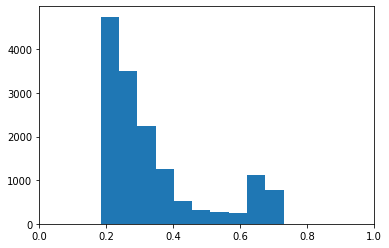

In [317]:
plt
plt.hist(result[0])
plt.xlim(0,1)

- 첫번째 모델의 변수

- 일자별 errtype 평균 갯수
- errtype (?)번
- 주차별 errtype 분산
- import tance 상위권 파라미터가 베이스라인 대체하는 순간부터는 빼고 진행 예정

In [328]:
result[2][0].feature_importance()

array([ 3,  2,  1,  0,  0,  5, 22,  0,  0,  1,  0,  0,  0,  3,  0,  0,  2,
        1,  0,  0,  7,  1,  0,  1, 13,  0,  0,  0,  1,  0,  2,  0,  2,  1,
        0,  0, 16,  8,  0,  1,  1,  7,  2,  0,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,  4,  3,  1,  0,  0,
        0,  0,  4,  0,  6,  0,  3,  1,  0,  0,  3,  1,  0,  1,  4,  0,  0,
        0,  0,  1,  1,  0,  2,  0,  0,  0,  0,  1,  4,  2,  0,  0,  0,  3,
        3,  2,  1,  5, 13,  9,  0,  0,  0,  0,  0,  1,  4,  0,  2,  3,  0,
        0,  0,  2,  1,  4,  4,  4,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  7, 11,
        0,  0,  5,  3,  5,  1,  0,  0,  0,  3,  1,  1,  0,  5,  1,  0,  0,
        0,  2,  1,  2,  1,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0

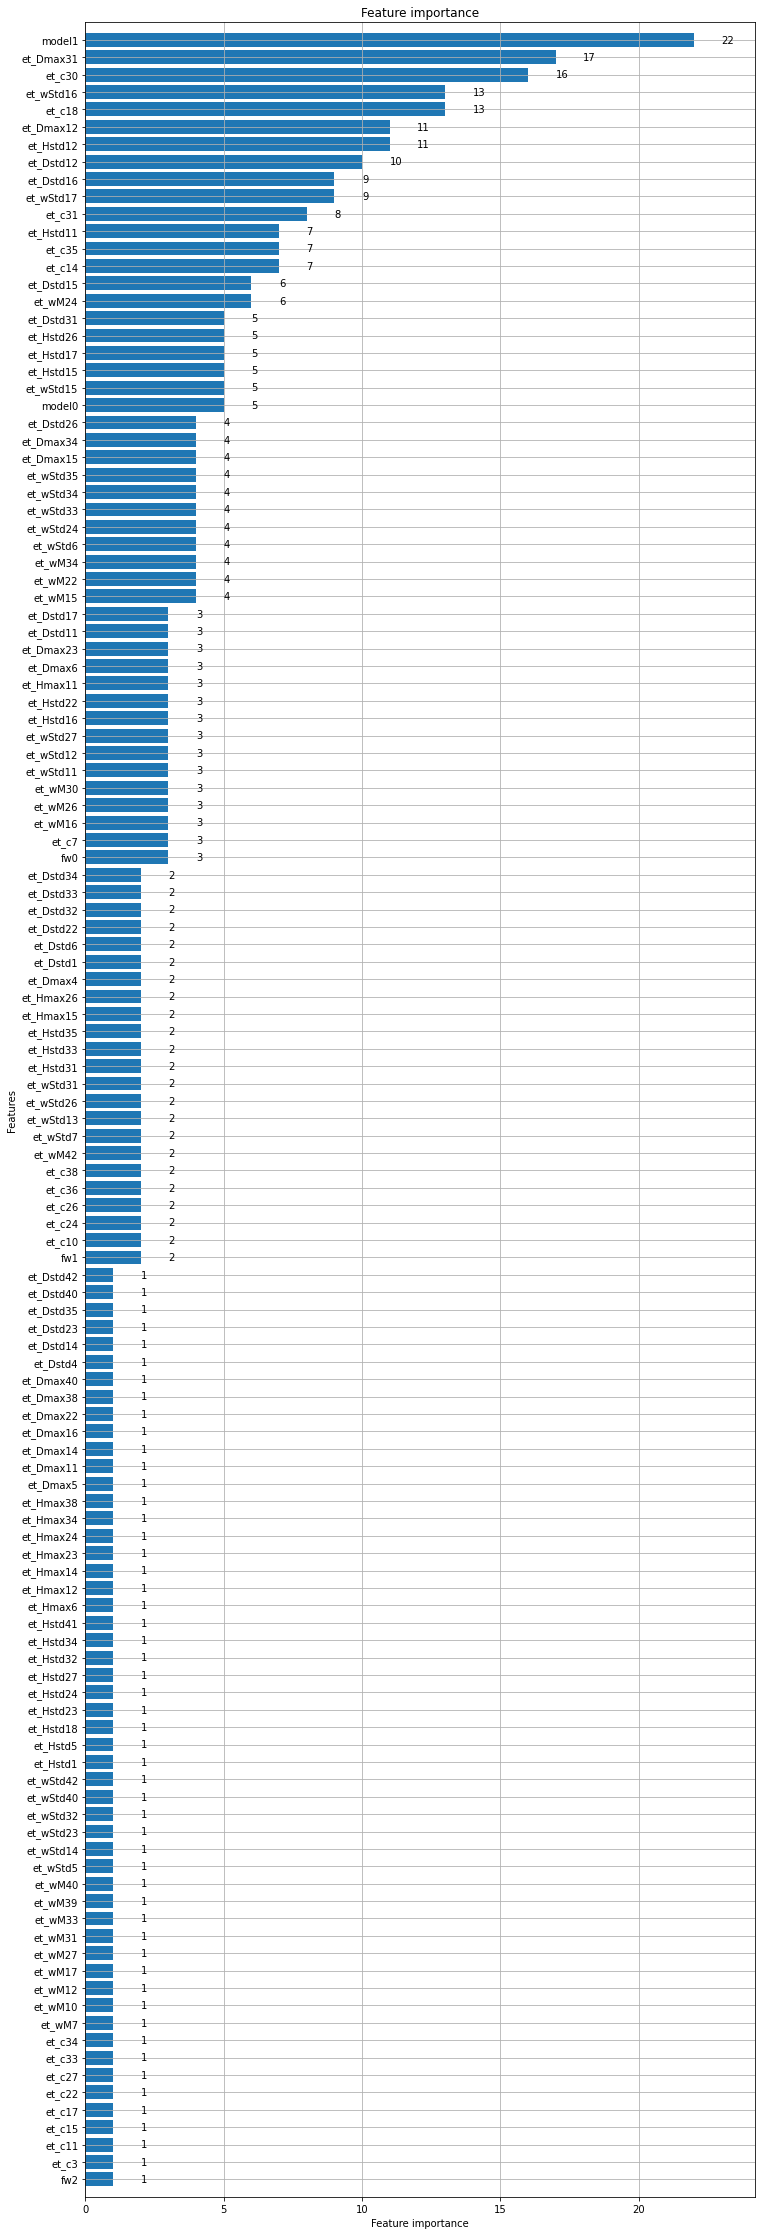

In [326]:
fig, ax = plt.subplots(figsize=(12,40))

lgb.plot_importance(result[2][0], max_num_features=300, height=0.8, ax=ax)
ax.set_yticks(range(0,50),range(0,100,2))
plt.show()

# EDA

In [7]:
pd.options.display.max_columns=50
pd.options.display.max_rows=200

In [11]:
tp=pd.read_csv(DATA_PATH+"train_problem_data.csv")

p_user = tp.user_id.unique()
np_user = list(set(tre.user_id.unique())  - set(p_user))

In [13]:
def get_distribution_errtype():
    total=[]
    for num in range(1,43):
        t1=tre.loc[tre.errtype==num]
        
        t11=t1.user_id.value_counts().describe().to_frame().T.rename(index={'user_id':num})
        pnumber=len(t1.loc[t1.user_id.isin(p_user)].user_id.unique())
        npnumber=len(t1.loc[t1.user_id.isin(np_user)].user_id.unique())
        
        
        t11['p_counts'] =pnumber
        t11['npnumber'] =npnumber
        if pnumber+npnumber ==0:
            t11['p_ratio']  = round((pnumber/1)*100,2)
        else:
            t11['p_ratio']  = round((pnumber/(pnumber+npnumber))*100,2)
            
        total.append(t11)

    
    return pd.concat(total).reset_index().rename(columns={'index':'errtype'})

errtpye_distribution = get_distribution_errtype()

errtpye_distribution

,errtype,count,mean,std,min,25%,50%,75%,max,p_counts,npnumber,p_ratio
0,1,950.0,22.678947,18.943070,1.0,2.0,30.0,30.0,171.0,242,708,25.47
1,2,390.0,66.938462,352.626788,1.0,2.0,2.0,6.0,4056.0,168,222,43.08
2,3,1679.0,18.319238,210.186901,1.0,1.0,2.0,5.0,7284.0,465,1214,27.70
3,4,6881.0,188.453713,2778.822793,1.0,1.0,17.0,152.0,195228.0,2298,4583,33.40
4,5,11010.0,86.550409,261.247025,1.0,3.0,9.0,49.0,6637.0,4028,6982,36.58
5,6,6467.0,7.806092,47.292207,1.0,1.0,2.0,4.0,1796.0,2662,3805,41.16
6,7,7648.0,6.798248,46.755629,1.0,1.0,2.0,4.0,2687.0,3093,4555,40.44
7,8,64.0,2.593750,2.549315,1.0,1.0,2.0,3.0,19.0,13,51,20.31
8,9,63.0,1.730159,2.444258,1.0,1.0,1.0,1.0,17.0,38,25,60.32
9,10,2360.0,56.526695,1064.242805,1.0,1.0,2.0,6.0,49106.0,1134,1226,48.05


In [14]:
def make(num):
    err1=tre.loc[tre.errtype==num]
    users=err1.user_id.value_counts().to_frame().index
    t2 =err1.loc[err1.user_id.isin(users)]
    t2['err_'+str(num)] = t2.time.dt.hour

    p = t2.loc[t2.user_id.isin(p_user)]
    np = t2.loc[t2.user_id.isin(np_user)]

    pdf =p['err_'+str(num)].value_counts().sort_index().to_frame().T.rename(index={'err_'+str(num):'err_p_'+str(num)})
    npdf =np['err_'+str(num)].value_counts().sort_index().to_frame().T.rename(index={'err_'+str(num):'err_np_'+str(num)})

    f = pd.concat([pdf,npdf])
    f2= f.copy()
    f=f.fillna(0)
#     X_MinMax_scaled = minmax_scale(f, axis=1, copy=True)
#     f.iloc[:,:]=X_MinMax_scaled*100
    f=round(f)
    return f,f2

In [15]:
t = []
for v in range(1,43):
    if v==29:
        pass
    else:
        
        df,_ = make(v)
        t.append(df)


tt = pd.concat(t).fillna(0)

tv=tt.T.corr()

tv1=tv.loc[tv.index.str.contains('np')].iloc[:,::2]

d =[]
for v in range(41):
    if v==28:
        d.append(0)
        vv=tv1.iloc[v,v]
    else:  
        vv=tv1.iloc[v,v]
    d.append(vv)
codf = pd.DataFrame(d).reset_index().rename(columns={'index':'errtype',0:'n_np_cor_hour_counts'})
codf['errtype'] =codf['errtype']+1


In [16]:
pd.merge(codf,errtpye_distribution)

,errtype,n_np_cor_hour_counts,count,mean,std,min,25%,50%,75%,max,p_counts,npnumber,p_ratio
0,1,0.996303,950.0,22.678947,18.943070,1.0,2.0,30.0,30.0,171.0,242,708,25.47
1,2,0.396358,390.0,66.938462,352.626788,1.0,2.0,2.0,6.0,4056.0,168,222,43.08
2,3,0.301628,1679.0,18.319238,210.186901,1.0,1.0,2.0,5.0,7284.0,465,1214,27.70
3,4,0.762725,6881.0,188.453713,2778.822793,1.0,1.0,17.0,152.0,195228.0,2298,4583,33.40
4,5,0.975115,11010.0,86.550409,261.247025,1.0,3.0,9.0,49.0,6637.0,4028,6982,36.58
5,6,-0.237164,6467.0,7.806092,47.292207,1.0,1.0,2.0,4.0,1796.0,2662,3805,41.16
6,7,0.440525,7648.0,6.798248,46.755629,1.0,1.0,2.0,4.0,2687.0,3093,4555,40.44
7,8,-0.040990,64.0,2.593750,2.549315,1.0,1.0,2.0,3.0,19.0,13,51,20.31
8,9,0.566893,63.0,1.730159,2.444258,1.0,1.0,1.0,1.0,17.0,38,25,60.32
9,10,0.062688,2360.0,56.526695,1064.242805,1.0,1.0,2.0,6.0,49106.0,1134,1226,48.05


In [323]:
def draw_each_num(num):
    t1=tre.loc[tre.errtype==num]
    t11=t1.user_id.value_counts().describe().to_frame().T.rename(index={'user_id':10})
    t12=t1.user_id.value_counts()

    users=t1.user_id.value_counts().to_frame().index
    plt.figure(figsize=(20,10))
    for i,v in enumerate(users):
        if v in p_user:
            df =t1.loc[t1.user_id ==v].time.values
            plt.scatter(df,np.ones(len(df))*i,c='b',s=0.3)
        else:
            df =t1.loc[t1.user_id ==v].time.values
            plt.scatter(df,np.ones(len(df))*i,c='r',s=0.3)        
    plt.show()

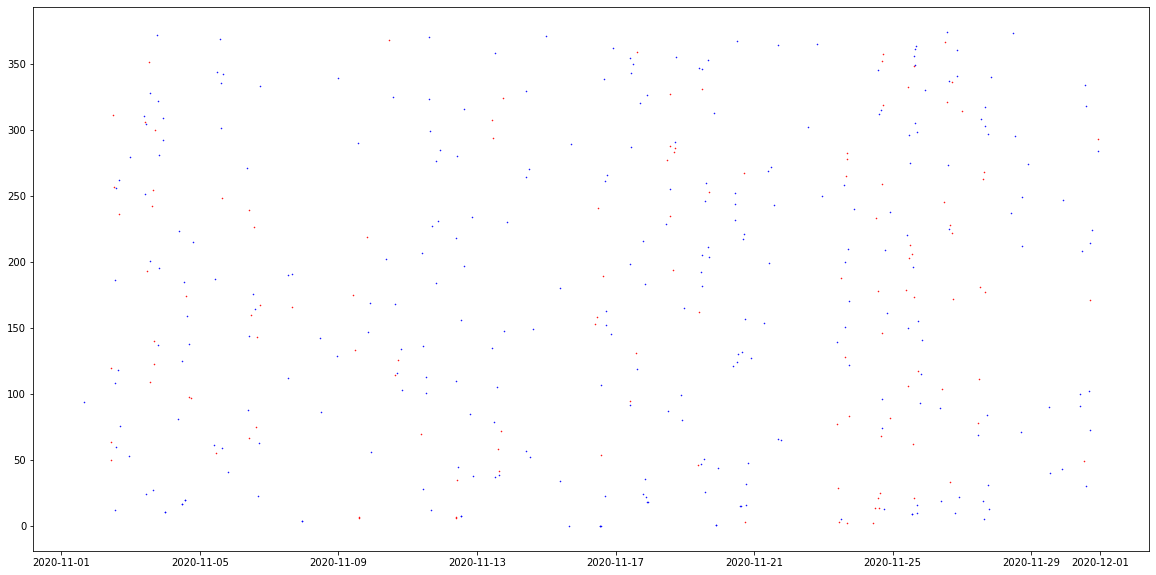

In [324]:
draw_each_num(30)

In [38]:
pnum = t1.loc[t1.user_id.isin(p_user)]
npnum = t1.loc[t1.user_id.isin(np_user)]

ppd =pnum.hours.value_counts().sort_index()
nppd =npnum.hours.value_counts().sort_index() 

In [60]:
for v in range(1,43):
    t1=tre.loc[tre.errtype==v]
    t1['hours'] = t1.time.dt.hour

    pnum = t1.loc[t1.user_id.isin(p_user)]
    npnum = t1.loc[t1.user_id.isin(np_user)]

    ppd =pnum.hours.value_counts().sort_index()
    nppd =npnum.hours.value_counts().sort_index() 
    redf =pd.concat([ppd,nppd],axis=1)
    redf.columns =['p','np']
    print("errtype",v)
    print('problem :',len(pnum.user_id.unique()),'nproblem :',len(npnum.user_id.unique()))
    redf =redf.reset_index().rename(columns={'index':'hours'})
    print('corr ',redf[['p','np']].corr().iloc[0,1])
    display(redf)

errtype 1
problem : 242 nproblem : 708
corr  0.9963030702227316


,hours,p,np
0,0,13,78
1,1,8,40
2,2,903,3971
3,3,910,3904
4,4,879,4168
5,5,542,2058
6,6,18,123
7,7,40,146
8,8,79,154
9,9,35,151


errtype 2
problem : 168 nproblem : 222
corr  0.39635837672296653


,hours,p,np
0,0,444,1196
1,1,747,828
2,2,500,426
3,3,274,503
4,4,209,425
5,5,123,376
6,6,51,334
7,7,214,368
8,8,264,633
9,9,323,275


errtype 3
problem : 465 nproblem : 1214
corr  0.3016275936620317


,hours,p,np
0,0,353,672
1,1,512,549
2,2,391,642
3,3,488,716
4,4,698,663
5,5,793,955
6,6,698,790
7,7,604,956
8,8,446,604
9,9,551,569


errtype 4
problem : 2298 nproblem : 4583
corr  0.7627254992220474


,hours,p,np
0,0,12731,34258
1,1,13017,30718
2,2,13929,35460
3,3,13417,36074
4,4,13981,37699
5,5,15443,38629
6,6,16360,39155
7,7,19976,44527
8,8,18268,43572
9,9,16879,41348


errtype 5
problem : 4028 nproblem : 6982
corr  0.9751152563167661


,hours,p,np
0,0,17822,23053
1,1,12411,14571
2,2,9211,11242
3,3,7118,8582
4,4,6092,7377
5,5,5426,6727
6,6,5859,6303
7,7,8616,12462
8,8,13805,16599
9,9,17497,21631


errtype 6
problem : 2662 nproblem : 3805
corr  -0.23716434276800089


,hours,p,np
0,0,1019,731
1,1,959,930
2,2,1024,976
3,3,1100,1207
4,4,935,1016
5,5,1153,1364
6,6,1040,1153
7,7,1030,1293
8,8,1018,733
9,9,1063,796


errtype 7
problem : 3093 nproblem : 4555
corr  0.4405252177667859


,hours,p,np
0,0,1019,693
1,1,933,778
2,2,1073,916
3,3,1106,957
4,4,995,922
5,5,1188,1315
6,6,1051,1112
7,7,1054,1226
8,8,1023,638
9,9,1072,678


errtype 8
problem : 13 nproblem : 51
corr  -0.17075616353915044


,hours,p,np
0,0,1.0,4.0
1,1,NaN,5.0
2,6,NaN,3.0
3,8,NaN,2.0
4,9,NaN,8.0
5,10,1.0,12.0
6,11,8.0,7.0
7,12,NaN,5.0
8,13,6.0,1.0
9,14,NaN,5.0


errtype 9
problem : 38 nproblem : 25
corr  0.6490390672658906


,hours,p,np
0,0,NaN,1.0
1,1,2.0,2.0
2,2,1.0,NaN
3,4,NaN,1.0
4,5,NaN,2.0
5,6,NaN,3.0
6,7,NaN,1.0
7,8,1.0,1.0
8,9,1.0,NaN
9,10,2.0,2.0


errtype 10
problem : 1134 nproblem : 1226
corr  0.06268848799001087


,hours,p,np
0,0,30286,1404
1,1,1976,1193
2,2,1810,7754
3,3,2329,1364
4,4,1971,979
5,5,1774,1012
6,6,1871,880
7,7,1805,1076
8,8,1992,1036
9,9,1857,1116


errtype 11
problem : 4971 nproblem : 9796
corr  0.9985578829724062


,hours,p,np
0,0,2529,2179
1,1,2225,1789
2,2,15569,29769
3,3,16623,32553
4,4,17614,32936
5,5,10738,18252
6,6,2765,2771
7,7,3385,3556
8,8,3644,3424
9,9,3320,3404


errtype 12
problem : 4974 nproblem : 9825
corr  0.9984337723065813


,hours,p,np
0,0,2527,2319
1,1,2414,1933
2,2,15803,29906
3,3,16830,32819
4,4,17847,33219
5,5,11186,19011
6,6,3196,3400
7,7,3766,4282
8,8,3825,3716
9,9,3549,3608


errtype 13
problem : 1667 nproblem : 2044
corr  0.2925313375264171


,hours,p,np
0,0,714,159
1,1,641,172
2,2,683,254
3,3,549,268
4,4,707,286
5,5,763,691
6,6,906,556
7,7,901,679
8,8,741,161
9,9,898,175


errtype 14
problem : 3224 nproblem : 4667
corr  -0.6196290002592895


,hours,p,np
0,0,4258,5823
1,1,4078,4151
2,2,3604,5004
3,3,3992,6437
4,4,4197,6561
5,5,4741,6371
6,6,4510,6047
7,7,4640,6297
8,8,5298,4667
9,9,4928,5900


errtype 15
problem : 4978 nproblem : 9567
corr  0.9699215989132638


,hours,p,np
0,0,28188,45661
1,1,17146,28429
2,2,43685,77568
3,3,43639,77198
4,4,43320,77360
5,5,27226,46222
6,6,11202,17807
7,7,17800,28204
8,8,26619,37450
9,9,26224,35341


errtype 16
problem : 4977 nproblem : 9454
corr  0.9812086703766034


,hours,p,np
0,0,9630,15639
1,1,6432,10108
2,2,4805,7545
3,3,4417,6973
4,4,5558,9387
5,5,9873,16418
6,6,19097,29405
7,7,32230,46395
8,8,33875,45643
9,9,27739,36911


errtype 17
problem : 2498 nproblem : 3249
corr  0.9727555395185902


,hours,p,np
0,0,612,660
1,1,226,313
2,2,149,243
3,3,161,371
4,4,238,332
5,5,526,628
6,6,1150,1515
7,7,2205,2375
8,8,2066,2192
9,9,1431,1621


errtype 18
problem : 1521 nproblem : 247
corr  0.8700232456069996


,hours,p,np
0,0,11,12
1,1,16,6
2,2,10,2
3,3,3,1
4,4,3,1
5,5,2,3
6,6,14,2
7,7,14,5
8,8,59,8
9,9,132,15


errtype 19
problem : 346 nproblem : 73
corr  0.36500664613579026


,hours,p,np
0,0,8.0,8.0
1,1,6.0,6.0
2,2,4.0,NaN
3,3,NaN,1.0
4,4,1.0,NaN
5,5,1.0,3.0
6,6,12.0,NaN
7,7,5.0,1.0
8,8,26.0,2.0
9,9,24.0,9.0


errtype 20
problem : 1333 nproblem : 213
corr  0.8970742799716042


,hours,p,np
0,0,10,11
1,1,7,6
2,2,6,2
3,3,3,1
4,4,2,1
5,5,1,3
6,6,6,1
7,7,7,2
8,8,39,7
9,9,100,14


errtype 21
problem : 316 nproblem : 65
corr  0.3641711620576024


,hours,p,np
0,0,8.0,8.0
1,1,6.0,6.0
2,2,4.0,NaN
3,3,NaN,1.0
4,4,1.0,NaN
5,5,1.0,3.0
6,6,5.0,NaN
7,7,5.0,1.0
8,8,26.0,NaN
9,9,24.0,8.0


errtype 22
problem : 3975 nproblem : 6306
corr  0.8085445929859063


,hours,p,np
0,0,33481,34096
1,1,27635,27034
2,2,41481,53347
3,3,41233,52810
4,4,39934,51132
5,5,29177,32920
6,6,21087,18400
7,7,27232,22896
8,8,34633,29762
9,9,37341,30039


errtype 23
problem : 3920 nproblem : 6126
corr  0.9562088494815988


,hours,p,np
0,0,46868,44056
1,1,37766,34897
2,2,36190,34611
3,3,35488,32000
4,4,32752,28324
5,5,28592,23114
6,6,28621,22582
7,7,37792,28020
8,8,48539,37465
9,9,51929,38009


errtype 24
problem : 1166 nproblem : 1353
corr  0.7101577342968919


,hours,p,np
0,0,548,941
1,1,403,778
2,2,430,802
3,3,447,710
4,4,527,793
5,5,394,696
6,6,437,670
7,7,776,683
8,8,827,762
9,9,754,742


errtype 25
problem : 360 nproblem : 60
corr  0.3269019857391607


,hours,p,np
0,0,12,6.0
1,1,11,2.0
2,2,12,3.0
3,3,3,NaN
4,6,2,2.0
5,7,13,7.0
6,8,35,1.0
7,9,84,2.0
8,10,69,10.0
9,11,46,5.0


errtype 26
problem : 4632 nproblem : 8394
corr  0.9970860513842615


,hours,p,np
0,0,55512,90589
1,1,7598,13639
2,2,3819,6480
3,3,3043,5188
4,4,3828,6657
5,5,6983,12048
6,6,13191,20833
7,7,20915,30860
8,8,18020,26142
9,9,11625,17540


errtype 27
problem : 958 nproblem : 1309
corr  0.6135296133739533


,hours,p,np
0,0,6051,8493
1,1,6040,6907
2,2,6475,9204
3,3,7889,9598
4,4,8450,9243
5,5,9454,10365
6,6,8911,8738
7,7,10883,10723
8,8,12356,9031
9,9,14082,10641


errtype 28
problem : 959 nproblem : 1316
corr  0.6079780671773457


,hours,p,np
0,0,6062,8673
1,1,6039,6997
2,2,6482,9304
3,3,7904,9761
4,4,8478,9456
5,5,9469,10449
6,6,8919,8932
7,7,10912,10844
8,8,12378,9101
9,9,14089,10833


errtype 29
problem : 0 nproblem : 0
corr  nan


,hours,p,np


errtype 30
problem : 260 nproblem : 115
corr  0.421751412783137


,hours,p,np
0,6,1,NaN
1,8,1,NaN
2,9,23,9.0
3,10,21,15.0
4,11,18,17.0
5,12,19,7.0
6,13,33,7.0
7,14,21,17.0
8,15,22,16.0
9,16,26,16.0


errtype 31
problem : 4153 nproblem : 6938
corr  0.971594589526596


,hours,p,np
0,0,19635,28343
1,1,13555,19663
2,2,16184,26677
3,3,15362,26332
4,4,16022,27884
5,5,17180,28474
6,6,25500,36928
7,7,45153,59541
8,8,50545,60715
9,9,44755,51563


errtype 32
problem : 927 nproblem : 1006
corr  0.9167428812095328


,hours,p,np
0,0,25358,27321
1,1,25853,28338
2,2,22728,26495
3,3,24898,28744
4,4,20515,23915
5,5,18460,21187
6,6,16675,20400
7,7,17890,21829
8,8,20250,22191
9,9,19969,20947


errtype 33
problem : 4138 nproblem : 6936
corr  0.9992715149292903


,hours,p,np
0,0,471,627
1,1,361,456
2,2,11605,20682
3,3,12400,22295
4,4,12925,22810
5,5,7228,12266
6,6,927,1380
7,7,1518,1994
8,8,1452,1796
9,9,1435,1706


errtype 34
problem : 1963 nproblem : 1770
corr  0.9436396032128554


,hours,p,np
0,0,2863,1214
1,1,2043,501
2,2,1096,244
3,3,964,282
4,4,891,279
5,5,1019,320
6,6,2679,475
7,7,4281,1141
8,8,5207,2310
9,9,5325,2032


errtype 35
problem : 1186 nproblem : 853
corr  0.8326079002313169


,hours,p,np
0,0,259,132
1,1,157,134
2,2,212,41
3,3,158,49
4,4,57,41
5,5,70,13
6,6,79,39
7,7,112,46
8,8,175,69
9,9,304,83


errtype 36
problem : 3262 nproblem : 5173
corr  0.9966073138350372


,hours,p,np
0,0,12,26
1,1,12,8
2,2,681,1088
3,3,809,1311
4,4,882,1381
5,5,564,854
6,6,67,109
7,7,61,101
8,8,45,72
9,9,68,63


errtype 37
problem : 3259 nproblem : 5175
corr  0.9964984408301591


,hours,p,np
0,0,12,26
1,1,12,8
2,2,681,1088
3,3,807,1310
4,4,883,1382
5,5,565,856
6,6,67,109
7,7,63,101
8,8,45,71
9,9,69,63


errtype 38
problem : 927 nproblem : 895
corr  0.9492348167332397


,hours,p,np
0,0,96,81
1,1,46,65
2,2,43,53
3,3,35,44
4,4,36,55
5,5,48,40
6,6,51,47
7,7,88,72
8,8,69,85
9,9,98,78


errtype 39
problem : 405 nproblem : 361
corr  0.8889090306270271


,hours,p,np
0,0,589,542
1,1,463,381
2,2,380,435
3,3,256,148
4,4,230,123
5,5,207,105
6,6,138,130
7,7,257,178
8,8,268,256
9,9,238,335


errtype 40
problem : 4052 nproblem : 6410
corr  0.9653170162652118


,hours,p,np
0,0,12117,16595
1,1,8438,11718
2,2,7168,9885
3,3,4999,6507
4,4,4893,6339
5,5,6240,8020
6,6,9879,11928
7,7,14258,17822
8,8,16441,19312
9,9,15699,17955


errtype 41
problem : 2596 nproblem : 3546
corr  0.9373810633097861


,hours,p,np
0,0,1518,2376
1,1,781,1258
2,2,495,698
3,3,302,455
4,4,253,362
5,5,225,344
6,6,315,448
7,7,1136,896
8,8,2170,1579
9,9,2130,1939


errtype 42
problem : 2490 nproblem : 3892
corr  0.999489460350038


,hours,p,np
0,0,6,11
1,1,3,7
2,2,3009,6016
3,3,3249,6281
4,4,3444,6667
5,5,1748,3109
6,6,4,6
7,7,7,11
8,8,21,12
9,9,20,20


상관 관계가 높은 녀석들은 주목할 필요가 없다고 본다.      
err 13, err 14 ,err 42 에 대해 추가분석

In [23]:
tq =pd.read_csv(DATA_PATH+"train_quality_data.csv")

In [24]:
tq.time =pd.to_datetime(tq.time.astype('str'))

In [25]:
tq_c=tq[['time','user_id']].drop_duplicates()

In [28]:
tp.time = pd.to_datetime(tp.time.astype('int'))

In [29]:
tp['mins']=tp.time.dt.minute

In [30]:
tp.time =pd.to_datetime(tp.time.astype('str'))

In [31]:
import datetime

In [117]:
n=0
for i,(idx , t) in enumerate(tqdm(tp[['user_id','time']].values)):
    d1=tq_c.loc[(tq_c.user_id ==idx) &(tq_c.time ==t)]
    d2=tq_c.loc[(tq_c.user_id ==idx) &(tq_c.time ==t-datetime.timedelta(hours=1))]
    d3=tq_c.loc[(tq_c.user_id ==idx) &(tq_c.time ==t-datetime.timedelta(hours=2))]
    if len(d1)+len(d2)+len(d3) !=0:
        n+=1


100%|██████████| 5429/5429 [00:10<00:00, 522.76it/s]


In [ ]:
tp=pd.read_csv(DATA_PATH+"train_problem_data.csv")

p_user = tp.user_id.unique()
np_user = list(set(tre.user_id.unique())  - set(p_user))

DATA_PATH = '/Users/ds/Documents/data/data/'
SAVE_PATH ='/Users/ds/Documents/data/result/'
tre = pd.read_csv(DATA_PATH+"train_err_datetime.csv")

dp = tre[['user_id','model_nm','fwver']]

unique_data =tre[(dp !=dp.shift(1)).sum(axis=1)>0]

fwver_total_dic ={}
for v in range(len(fwver_total)):
    fwver_total_dic[sorted(list(fwver_total))[v]] = v+1

def fwver_tran(x):
    return fwver_total_dic[x]

fwver = np.zeros((15000,5))
for idx in tqdm(unique_data.user_id.unique()):
    df = unique_data.loc[unique_data.user_id==idx].fwver.values
    for l in range(len(df)):
        fwver[idx-10000,l] =fwver_total_dic[df[l]]

fw_df = pd.DataFrame(fwver).reset_index().rename(columns={'index':'user_id'})

fwver_total_dic_rev = {v: k for k, v in fwver_total_dic.items()}
fwver_total_dic_rev[0] =0

def fwver_tras_reverse(x):
    return fwver_total_dic_rev[x]

fw_df[0] =fw_df[0].apply(fwver_tras_reverse)
fw_df[1] =fw_df[1].apply(fwver_tras_reverse)
fw_df[2] =fw_df[2].apply(fwver_tras_reverse)
fw_df[3] =fw_df[3].apply(fwver_tras_reverse)
fw_df[4] =fw_df[4].apply(fwver_tras_reverse)

fw_df['user_id'] +=10000

def model(x):
    if x in p_user:
        return 1
    else:
        return 0

fw_df['pb'] =fw_df.user_id.apply(model)

fw_df2=fw_df.loc[fw_df.pb ==1]
pfw = fw_df2[[0,1,2,3,4]].value_counts().to_frame().rename(columns={0:'problem'}).reset_index().sort_values(0)\
.rename(columns={0:'fw1',1:'fw2',2:'fw3',3:'fw4',4:'fw5'}).reset_index(drop=True)

fw_df2=fw_df.loc[fw_df.pb ==0]
npfw = fw_df2[[0,1,2,3,4]].value_counts().to_frame().rename(columns={0:'non-problem'}).reset_index().sort_values(0)\
.rename(columns={0:'fw1',1:'fw2',2:'fw3',3:'fw4',4:'fw5'}).reset_index(drop=True)

fw_t= fw_df[[0,1,2,3,4]].value_counts().to_frame().rename(columns={0:'counts'}).reset_index().sort_values(0)\
.rename(columns={0:'fw1',1:'fw2',2:'fw3',3:'fw4',4:'fw5'}).reset_index(drop=True)

s1=pd.merge(fw_t,pfw,how='outer').fillna(0)
s2=pd.merge(s1,npfw,how='outer').fillna(0)

s2['problem'] =s2['problem'].astype('int')
s2['non-problem'] =s2['non-problem'].astype('int')
s2['problem-ratio'] = round(s2['problem']/s2['counts'] *100,2)

s2

In [259]:
s3=s2.loc[s2.counts>100]
s3.loc[s3['problem-ratio']>80]

,fw1,fw2,fw3,fw4,fw5,counts,problem,non-problem,problem-ratio
24,04.16.3553,04.33.1185,04.33.1261,0,0,145,135,10,93.10
27,04.16.3553,04.33.1261,0,0,0,267,250,17,93.63


04.16.3553	04.16.3571	04.16.3553	04.33.1261 -> 백프로임! 유심히 살펴볼것      
04.16.3553	04.16.3571	04.16.3553	04.33.1149	04.33.1261     
04.16.3553	04.16.3571	04.16.3553	 -> 이녀석이 예외 (펌웨어 회귀하는 녀석들 중에서)      

In [261]:
s2

,fw1,fw2,fw3,fw4,fw5,counts,problem,non-problem,problem-ratio
0,03.11.1141,0,0,0,0,1,0,1,0.00
1,03.11.1141,03.11.1167,0,0,0,1,1,0,100.00
2,03.11.1149,0,0,0,0,5,0,5,0.00
3,03.11.1149,03.11.1167,0,0,0,1,0,1,0.00
4,03.11.1167,04.33.1149,04.33.1261,0,0,2,2,0,100.00
5,03.11.1167,04.33.1261,0,0,0,2,2,0,100.00
6,03.11.1167,0,0,0,0,673,133,540,19.76
7,04.16.2641,04.33.1261,0,0,0,1,1,0,100.00
8,04.16.3345,04.33.1185,04.33.1261,0,0,1,1,0,100.00
9,04.16.3345,0,0,0,0,1,0,1,0.00
